In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score

import sys
sys.path.append("../src")

In [2]:
air_reserve = pd.read_csv('../data/raw/air_reserve.csv')
air_store_info = pd.read_csv('../data/raw/air_store_info.csv')
air_visit_data = pd.read_csv('../data/raw/air_visit_data.csv')
date_info = pd.read_csv('../data/raw/date_info.csv')
hpg_reserve = pd.read_csv('../data/raw/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../data/raw/hpg_store_info.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
hpg_air_store_id_relation = pd.read_csv('../data/raw/store_id_relation.csv')

datasets = {
    'air_reserve': air_reserve,
    'air_store_info': air_store_info,
    'air_visit_data': air_visit_data,
    'date_info': date_info,
    'hpg_reserve': hpg_reserve,
    'hpg_store_info': hpg_store_info,
    'sample_submission': sample_submission,
    'hpg_air_store_id_relation': hpg_air_store_id_relation
}

for name, df in datasets.items():
    for col in df.columns:
        if df[col].dtype == "object" and ("date" in col.lower() or "time" in col.lower()):
            df[col] = pd.to_datetime(df[col], errors="coerce")

In [3]:
# Ensure datetime
air_visit_data["visit_date"] = pd.to_datetime(air_visit_data["visit_date"])
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])
date_info["calendar_date"] = pd.to_datetime(date_info["calendar_date"])

# --- 1) Aggregate daily AIR visits ---
air_daily = (
    air_visit_data
    .groupby("visit_date")["visitors"]
    .sum()
    .reset_index()
)

# --- 2) Aggregate daily HPG reservations (convert to 'visitors' style) ---
hpg_daily = (
    hpg_reserve
    .groupby(hpg_reserve["visit_datetime"].dt.date)["reserve_visitors"]
    .sum()
    .reset_index()
    .rename(columns={"visit_datetime": "visit_date", "reserve_visitors": "visitors"})
)

hpg_daily["visit_date"] = pd.to_datetime(hpg_daily["visit_date"])

# --- 3) Combine AIR + HPG into one daily total ---
all_visits = (
    pd.concat([air_daily, hpg_daily], ignore_index=True)
    .groupby("visit_date")["visitors"]
    .sum()
    .reset_index()
    .sort_values("visit_date")
)

# --- 4) Merge with holiday info (optional features) ---
df = all_visits.merge(
    date_info[["calendar_date", "holiday_flg"]].rename(columns={"calendar_date": "visit_date"}),
    on="visit_date", how="left"
)

# --- 5) Add simple calendar features ---
df["holiday_flg"] = df["holiday_flg"].fillna(0).astype(int)
df["visit_month"] = df["visit_date"].dt.month
df["visit_weekday"] = df["visit_date"].dt.dayofweek
df["is_weekend"] = (df["visit_weekday"] >= 5).astype(int)

# --- Define cutoff date (second last week of April 2017) ---
cutoff_date = pd.to_datetime("2017-04-22")

# --- Filter df ---
df = df[
    df["visit_date"] <= cutoff_date
].copy()

# Final dataset
df = df.sort_values("visit_date").reset_index(drop=True)
df.head()

,visit_date,visitors,holiday_flg,visit_month,visit_weekday,is_weekend
0,2016-01-01,1526,1,1,4,0
1,2016-01-02,4853,1,1,5,1
2,2016-01-03,5591,1,1,6,1
3,2016-01-04,6160,0,1,0,0
4,2016-01-05,6723,0,1,1,0


In [4]:
n_train = int(len(df) * 0.8)
X_train = df[:n_train]
X_test = df[n_train:]

# Grouping all visitors by date
daily_total = df.groupby("visit_date")["visitors"].sum()
daily_total

visit_date
2016-01-01     1526
2016-01-02     4853
2016-01-03     5591
2016-01-04     6160
2016-01-05     6723
              ...  
2017-04-18    32570
2017-04-19    40667
2017-04-20    38294
2017-04-21    89690
2017-04-22    71799
Name: visitors, Length: 478, dtype: int64

In [5]:
daily_total_copy = daily_total.to_frame()
daily_total_copy.columns = ['Counts']
daily_total_copy

,Counts
visit_date,
2016-01-01,1526
2016-01-02,4853
2016-01-03,5591
2016-01-04,6160
2016-01-05,6723
...,...
2017-04-18,32570
2017-04-19,40667
2017-04-20,38294


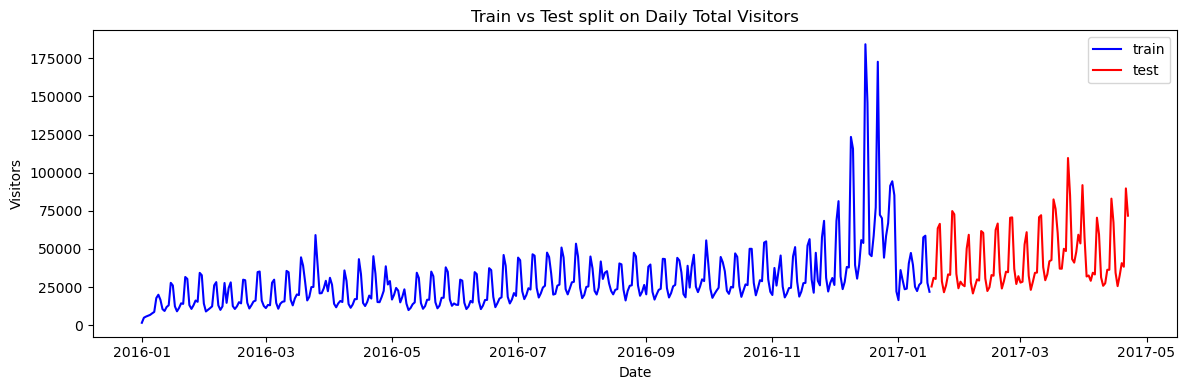

In [6]:
n_train = int(len(daily_total) * 0.8)
train, test = daily_total.iloc[:n_train], daily_total.iloc[n_train:]

plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, "b", label="train")
plt.plot(test.index, test.values, "r", label="test")
plt.title("Train vs Test split on Daily Total Visitors")
plt.xlabel("Date")
plt.ylabel("Visitors")
plt.legend()
plt.tight_layout()
plt.show()

## Checking Stationarity

In [7]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(daily_total_copy['Counts'])

ADF Statistic: -2.929757574677012
p-value: 0.041995417242188665
Stationary


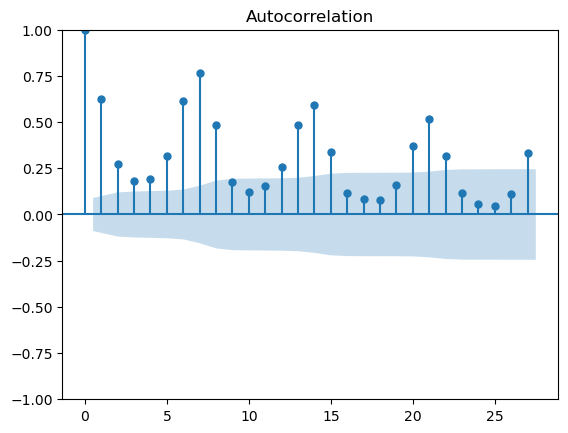

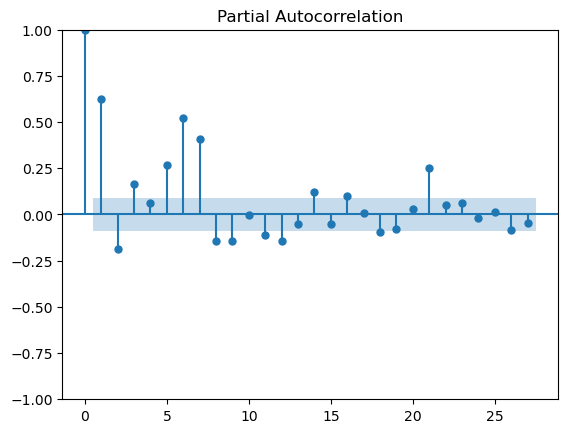

In [8]:
plot_acf(daily_total_copy)
plot_pacf(daily_total_copy)
plt.show()

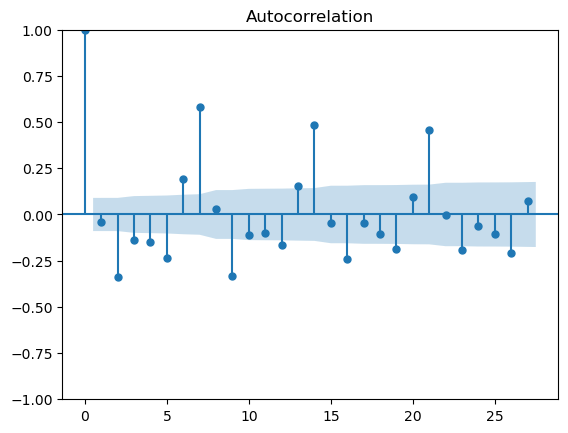

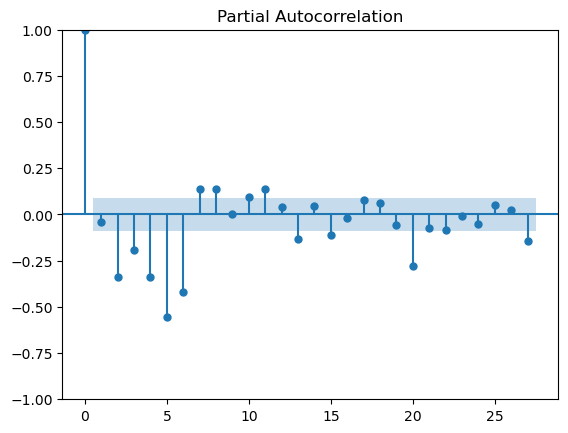

In [9]:
df_diff = daily_total_copy['Counts'].diff().dropna()

plot_acf(df_diff)
plot_pacf(df_diff)
plt.show()

**ARIMA(p, d, q)**

- p (AR): Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. In other words, how much the past values directly influence the current value.
	- If p = 1: today’s value depends on yesterday’s value.
	- If p = 2: it also depends on the day before yesterday, and so on.
- d (I): uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times. In other words, how many times we subtract consecutive values to remove trends and make the series stable.
	- If d = 0: we use the raw data.
	- If d = 1: we predict changes rather than absolute values (removes trend).
	- If d = 2: we remove stronger trends or curvature.
- q (MA): a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. In other words, how much past forecast errors (mistakes) are used to correct the current prediction.
	- q = 1: today’s value depends on yesterday’s error.
	- q = 2 → it also adjusts using the error from two days ago, and so on

- d = 1: The first differencing made the series stationary because the ACF values now oscillate around 0 (no persistent upward/downward trend), and most lags are within the confidence interval except the first one.
- p = 1: The PACF shows a strong spike at lag 1 and then quickly drops within the confidence bands, which indicates that only one autoregressive (AR) term is needed.
- q = 1: ACF (autocorrelation) plot has a strong spike at lag 1 and then quickly drops within the confidence band, that suggests q = 1

Thus, ARIMA(1,1,0) or ARIMA(1,1,1) are great starting models.

# ARIMA

In [10]:
def evaluate_arima_model(train, test, arima_order):
	# prepare training dataset
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	r2_score = 1 - (error / np.var(test))
	return error, r2_score, predictions

In [11]:
# Plot functions
def plot_results(train, test, preds):
    plt.figure(figsize=(12,4))
    plt.plot(range(len(train)), train, label="Train", color="blue")
    plt.plot(range(len(train), len(train)+len(test)), test, label="Test", color="red")
    plt.plot(range(len(train), len(train)+len(preds)), preds, label="Predictions", color="green")
    plt.legend()
    plt.title("ARIMA Model Predictions vs Actuals")
    plt.xlabel("Time")
    plt.ylabel("Visitors")
    plt.tight_layout()
    plt.show()

/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


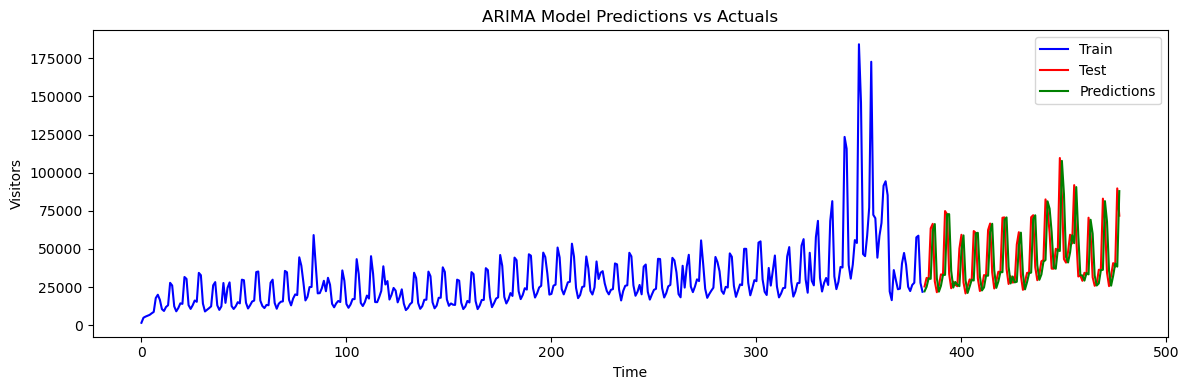

In [12]:
# Evaluate and plot
error, r2, predictions = evaluate_arima_model(train, test, (1,1,0))
plot_results(train, test, predictions)

In [13]:
# evaluate combinations of p, d and q values for an ARIMA model
def grid_search_arima(train, test, p_values, d_values, q_values):
    """
    Grid-search ARIMA (p,d,q) on a fixed train/test split.
    Selects the model with the lowest MSE.
    
    Returns
    -------
    best_order : tuple (p,d,q)
    results_df : pd.DataFrame with columns (p, d, q, mse, r2)
    """
    records = []
    best_mse = np.inf
    best_order = None
    best_predictions = None
    best_r2 = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mse, r2, predictions = evaluate_arima_model(train, test, order)
                print(f"ARIMA{order}  MSE={mse:.4f}  R²={r2:.4f}")
                records.append({"p": p, "d": d, "q": q, "mse": mse, "r2": r2})
                if mse < best_mse:
                    best_mse = mse
                    best_order = order
                    best_r2 = r2
                    best_predictions = predictions

    results_df = pd.DataFrame(records).sort_values("mse", ascending=True)
    print(f"\nBest ARIMA{best_order}  MSE={best_mse:.4f}  R^2={best_r2:.4f}")
    return best_order, results_df, best_predictions, best_r2

In [14]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_order, results_df, best_predictions, best_r2 = grid_search_arima(train, test, p_values, d_values, q_values)

/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 0, 0)  MSE=577196121.1607  R²=-0.5006


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 0, 1)  MSE=339944897.3521  R²=0.1162


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 0, 2)  MSE=322111977.0621  R²=0.1626


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 1, 0)  MSE=418637452.0312  R²=-0.0884


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 1, 1)  MSE=394639606.7765  R²=-0.0260


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(0, 1, 2)  MSE=281102275.3835  R²=0.2692


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 0, 0)  MSE=347996306.5457  R²=0.0953


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 0, 1)  MSE=321659610.7026  R²=0.1637


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 0, 2)  MSE=288568941.1475  R²=0.2498


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 1, 0)  MSE=420239524.6159  R²=-0.0925


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 1, 1)  MSE=316626422.8225  R²=0.1768


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(1, 1, 2)  MSE=280856127.9736  R²=0.2698


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 0, 0)  MSE=329390659.1378  R²=0.1436


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 0, 1)  MSE=321756876.8430  R²=0.1635


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 0, 2)  MSE=283392520.8475  R²=0.2632


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 1, 0)  MSE=370248212.0830  R²=0.0374


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 1, 1)  MSE=267891450.9530  R²=0.3035


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/3040219302.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


ARIMA(2, 1, 2)  MSE=218163570.3208  R²=0.4328

Best ARIMA(2, 1, 2)  MSE=218163570.3208  R^2=0.4328


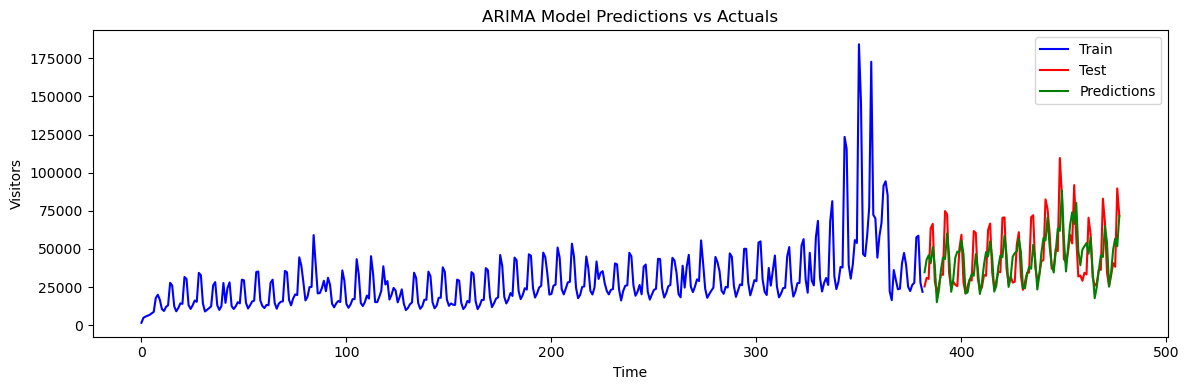

In [16]:
plot_results(train, test, best_predictions)

# SARIMA

**SARIMA(p, d, q)(P, D, Q, s)**

- Non-seasonal (p, d, q) — same idea as ARIMA:
    - p from PACF (non-seasonal lags: 1,2,3…)
	- q from ACF
	- d = how many regular differences you needed to make the series stationary.
- Seasonal (P, D, Q, s) — capture repeating cycles every s steps:
    - P from PACF spikes at seasonal lags (s, 2s, …).
    - D = how many seasonal differences you needed (often D=1 if you still see seasonality after regular differencing).
    - Q from ACF spikes at seasonal lags (s, 2s, …).
	- s = the period (for daily restaurant data, usually 7 for weekly).

In [17]:
def evaluate_sarimax_model(train, test, order, seasonal_order=(0,0,0,0)):
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    r2 = r2_score(test, predictions)
    return error, r2, predictions

In [18]:
error ,r2 , predictions = evaluate_sarimax_model(train, test, best_order, (1,1,1,7))

/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


error: 58147073.53172994, r2: 0.8488279405199577


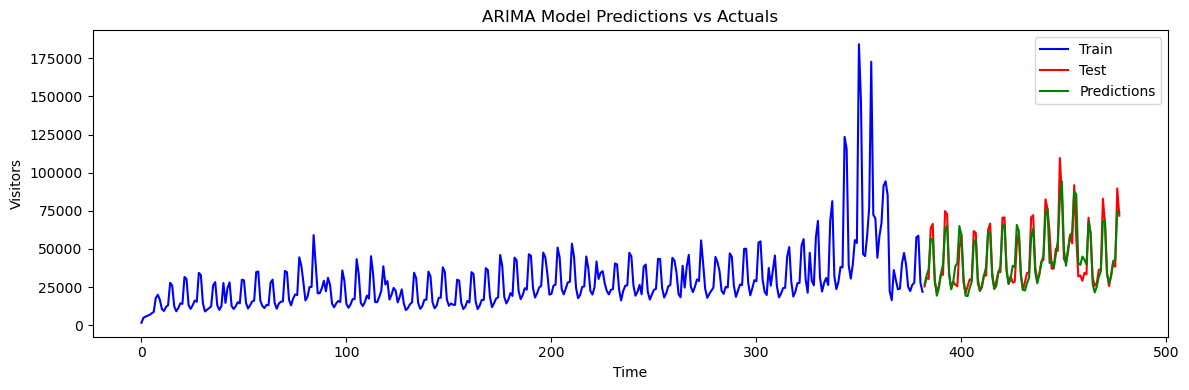

In [19]:
print(f'error: {error}, r2: {r2}')
plot_results(train = train, test = test, preds = predictions)


In [20]:
def grid_search_sarimax(train, test, order, P_values, D_values, Q_values, s_values):
    """
    Grid-search SARIMAX seasonal parameters (P, D, Q, m) on a fixed train/test split.
    Selects the model with the lowest MSE.

    Parameters
    ----------
    train, test : array-like
        Train and test data arrays
    order : tuple
        (p, d, q) non-seasonal order fixed
    P_values, D_values, Q_values : list
        Seasonal P, D, Q parameters to search
    s_values : list
        Seasonal periods to search (e.g., 7 for weekly)

    Returns
    -------
    best_seasonal_order : tuple (P,D,Q,m)
    results_df : pd.DataFrame with columns (P, D, Q, m, mse, r2)
    best_predictions : list
        Forecasted values for the best seasonal parameters
    best_r2 : float
        Best R² score
    """
    records = []
    best_mse = np.inf
    best_seasonal_order = None
    best_predictions = None
    best_r2 = None

    for P in P_values:
        for D in D_values:
            for Q in Q_values:
                for m in s_values:
                    seasonal_order = (P, D, Q, m)
                    mse, r2, predictions = evaluate_sarimax_model(train, test, order, seasonal_order)
                    print(f"SARIMAX{order}x{seasonal_order}  MSE={mse:.4f}  R²={r2:.4f}")
                    records.append({"P": P, "D": D, "Q": Q, "m": m, "mse": mse, "r2": r2})
                    if mse < best_mse:
                        best_mse = mse
                        best_seasonal_order = seasonal_order
                        best_predictions = predictions
                        best_r2 = r2

    results_df = pd.DataFrame(records).sort_values("mse", ascending=True)
    print(f"\nBest SARIMAX seasonal_order={best_seasonal_order}  MSE={best_mse:.4f}  R²={best_r2:.4f}")
    return best_seasonal_order, results_df, best_predictions, best_r2, best_mse

In [21]:
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = range(6, 8)

best_seasonal_order, results_df, best_predictions, best_r2, best_mse = grid_search_sarimax(train, test, best_order, P, D, Q, s)

/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 0, 0, 6)  MSE=234032230.2965  R²=0.3916


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 0, 0, 7)  MSE=234032230.2965  R²=0.3916


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 0, 1, 6)  MSE=258498784.8381  R²=0.3279


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 0, 1, 7)  MSE=158778557.4903  R²=0.5872


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 1, 0, 6)  MSE=361736406.7966  R²=0.0595


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 1, 0, 7)  MSE=73987365.1185  R²=0.8076


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 1, 1, 6)  MSE=215934073.4148  R²=0.4386


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(0, 1, 1, 7)  MSE=58815568.3850  R²=0.8471


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(1, 0, 0, 6)  MSE=263849972.8297  R²=0.3140


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(1, 0, 0, 7)  MSE=102115853.6659  R²=0.7345


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(1, 0, 1, 6)  MSE=256884310.6880  R²=0.3321


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 1, 2)x(1, 0, 1, 7)  MSE=52569954.6692  R²=0.8633


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(1, 1, 0, 6)  MSE=365741201.3095  R²=0.0491


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(1, 1, 0, 7)  MSE=64804559.9811  R²=0.8315


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(1, 1, 1, 6)  MSE=237923231.5934  R²=0.3814


/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_62733/27203608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])


SARIMAX(2, 1, 2)x(1, 1, 1, 7)  MSE=58147073.5317  R²=0.8488

Best SARIMAX seasonal_order=(1, 0, 1, 7)  MSE=52569954.6692  R²=0.8633


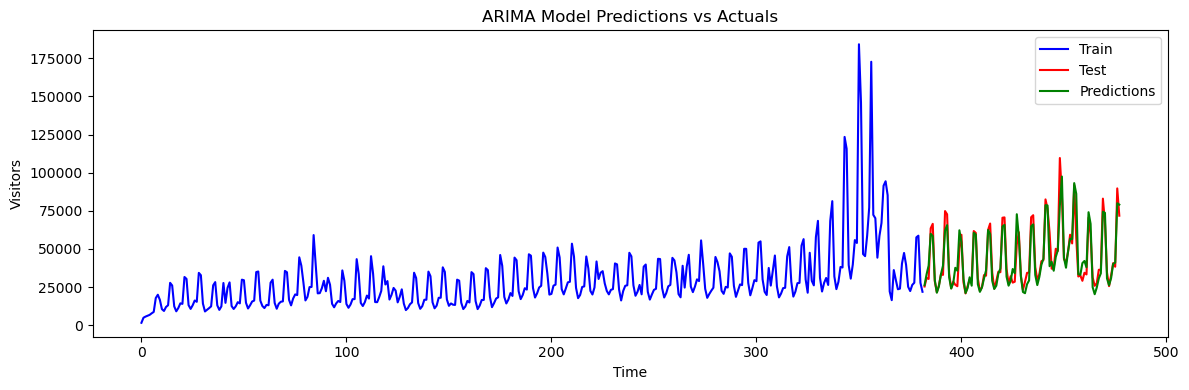

best MSE: 52569954.669223614 | best R^2: 0.8633274586074846


In [22]:
plot_results(train, test, best_predictions)
print(f'best MSE: {best_mse} | best R^2: {best_r2}')